# Titanic: Machine Learning Disaster

## Feature Engineering

In the following cells, we will engineer features that help address some of the challenges we saw during the exploratory phase:
- Missing values inputation
- Skewed variables
- Dealing with outliers
- Removing rare labels and conversion to numbers of categorical variables
- Standardizing the values to same range

Remember to always set the seed for reproducability

In [1]:
# to handle datasets
import pandas as pd
import numpy as np

# for plotting
import matplotlib.pyplot as plt

# to divide train and test set
from sklearn.model_selection import train_test_split

# feature scaling
from sklearn.preprocessing import MinMaxScaler

# to visualise al the columns in the dataframe
pd.set_option('display.max_columns', None)

import warnings
warnings.simplefilter(action='ignore')

In [2]:
# loading dataset
data = pd.read_csv('./titanic/train.csv')
print(data.shape)
data.head(3)

(891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


**Spliting data into train and test set**
It is important to do this before engineering new features as this prevents our preprocessing techniques from learning parameters in our data and this further help to avoid over-fiting.

In [3]:
X_train, X_test, y_train, y_test = train_test_split(data, data['Survived'], 
                                                    test_size =0.1, 
                                                    random_state=0)

X_train.shape, X_test.shape

((801, 12), (90, 12))

### Dealing with missing values

#### Numerical variables

There are different ways of engineering missing values in numerical varibales, but we will:
- add a binary missing value indicator
- then proceed to replace missing values with the median

In [4]:
# make a list of numerical varibales with missing values
vars_with_na = []

for var in data.columns:
    if data[var].isnull().sum() > 0 and data[var].dtypes != 'O':
        vars_with_na.append(var)
        
# percentage of missing value
print(data[vars_with_na].isnull().mean())

Age    0.198653
dtype: float64


In [5]:
# dealing with missing values

for var in vars_with_na:
    
#     get median value on train_set
    median_val = X_train[var].median()
#     add binary missing value indicator on both train and test
    X_train[var + '_na'] = np.where(X_train[var].isnull(), 1, 0)
    X_test[var + '_na'] = np.where(X_test[var].isnull(), 1, 0)
    
#     replace missing values by the median
    X_train[var] = X_train[var].fillna(median_val)
    X_test[var] = X_test[var].fillna(median_val)
    
# confirm that no more missing values
X_train[vars_with_na].isnull().sum()

Age    0
dtype: int64

In [6]:
# check for same on the test set
X_test[vars_with_na].isnull().sum()

Age    0
dtype: int64

In [7]:
X_train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age_na
815,816,0,1,"Fry, Mr. Richard",male,28.5,0,0,112058,0.0000,B102,S,1
877,878,0,3,"Petroff, Mr. Nedelio",male,19.0,0,0,349212,7.8958,NaN,S,0
193,194,1,2,"Navratil, Master. Michel M",male,3.0,1,1,230080,26.0000,F2,S,0


#### Categorical variables

During exploratory data analysis we discovered two categorical variables with missing values 'Cabin', 'Embarked', but a huge percentage is missing in the 'Cabin' variable.

In [8]:
# make a list of varibales with missing values
vars_with_na = []
for var in data.columns:
    if data[var].isnull().sum() > 0 and data[var].dtypes == 'O':
        vars_with_na.append(var)
# percentage of missing values
X_train[vars_with_na].isnull().mean()

Cabin       0.776529
Embarked    0.002497
dtype: float64

In [9]:
# Dealing with missing value

X_train[vars_with_na] = X_train[vars_with_na].fillna('Missing')
X_test[vars_with_na] = X_test[vars_with_na].fillna('Missing')

In [10]:
X_train[vars_with_na].isnull().sum()

Cabin       0
Embarked    0
dtype: int64

In [11]:
X_test[vars_with_na].isnull().sum()

Cabin       0
Embarked    0
dtype: int64

### Variable transformation

#### Numerical variable transformation

During the exploratory data analysis, we observed that a couple of variables are not normally distributed. Hence, we will log transform them.

In [12]:
for var in ['Age', 'Fare']:
    X_train[var] = np.log1p(X_train[var])
    X_test[var] = np.log1p(X_test[var])

In [13]:
# confirm that the transformation didn't introduce null values to our varibales
[var for var in ['Age', 'Fare'] if X_train[var].isnull().sum() > 0]

[]

In [14]:
# confirm that the transformation didn't introduce null values to our varibales
[var for var in ['Age', 'Fare'] if X_test[var].isnull().sum() > 0]

[]

#### Categorical variable transformation

**Removing rare labels**

Labels that are present in less than 1% in our categorical variables are replaced with the string 'Rare'.

In [15]:
# make a list of categorical variables
cat_vars = []
for var in data.columns:
    if data[var].dtypes == 'O':
        cat_vars.append(var)
        
data[cat_vars].head(3)

,Name,Sex,Ticket,Cabin,Embarked
0,"Braund, Mr. Owen Harris",male,A/5 21171,NaN,S
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,PC 17599,C85,C
2,"Heikkinen, Miss. Laina",female,STON/O2. 3101282,NaN,S


In [16]:
# X_train['Embarked'].unique()

In [17]:
def identify_frequent_labels(df, var, rare_perc):
    df = df.copy()
    
    tmp = df.groupby(var)['Survived'].count() / len(df)
    return tmp[tmp > rare_perc].index

for var in cat_vars:
#     identify frequent categories
    frequent_ls = identify_frequent_labels(X_train, var, 0.005)
    
#     replace rare categories with the string 'Rare'
    X_train[var] = np.where(X_train[var].isin(frequent_ls), X_train[var], 'Rare')
    X_test[var] = np.where(X_test[var].isin(frequent_ls), X_test[var], 'Rare')    

In [18]:
X_train.tail()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age_na
835,836,1,1,Rare,female,3.688879,1,1,Rare,4.432700,Rare,C,0
192,193,1,3,Rare,female,2.995732,1,0,Rare,2.180892,Missing,S,0
629,630,0,3,Rare,male,3.384390,0,0,Rare,2.167143,Missing,Q,1
559,560,1,3,Rare,female,3.610918,1,0,Rare,2.912351,Missing,S,0
684,685,0,2,Rare,male,4.110874,1,1,Rare,3.688879,Missing,S,0


In [19]:
X_train[cat_vars].nunique()

Name        1
Sex         2
Ticket      6
Cabin       2
Embarked    4
dtype: int64

**Encoding categorical**

This allows us to transform categorical varibales into numerical values.

In [20]:
def transform_categories(train, test, var, target):
#     order the categories in a varibale in ascending order of survival rate
    ordered_labels = train.groupby(var)[target].sum().sort_values().index
    
#     create a dictionary of ordered categories to integer values
    ordinal_label = {k: i for i, k in enumerate(ordered_labels, 0)}
    
     # use the dictionary to replace the categorical strings by integers
    train[var] = train[var].map(ordinal_label)
    test[var] = test[var].map(ordinal_label)
#     print(ordered_labels)
#     print(ordinal_label)

In [21]:
for var in cat_vars:
    transform_categories(X_train, X_test, var, 'Survived')

In [22]:
# check absence of na in the train set
[var for var in X_train.columns if X_train[var].isnull().sum() > 0]

[]

In [23]:
# check absence of na in the test set
[var for var in X_test.columns if X_test[var].isnull().sum() > 0]

[]

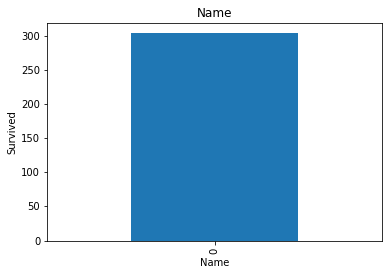

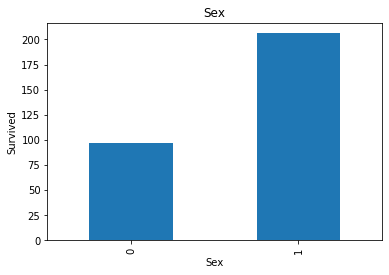

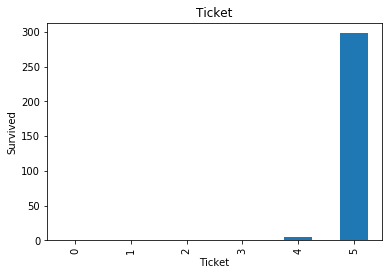

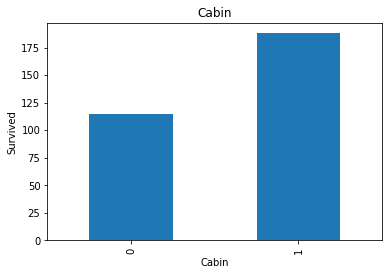

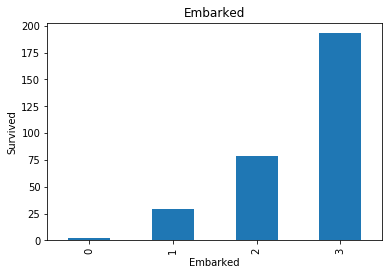

In [24]:
def explore_vars(df, var):
    
    # function plots median house sale price per encoded
    # category
    
    df = df.copy()
    df.groupby(var)['Survived'].sum().plot.bar()
    plt.title(var)
    plt.ylabel('Survived')
    plt.show()
    
for var in cat_vars:
    explore_vars(X_train, var)

### Variable scaling

It is important to have all variables on the same scale as this helps our model performance. 

In [25]:
# make a list of variables without the target and passenger id

train_vars = []

for var in X_train.columns:
    if var not in ['PassengerId', 'Survived']:
        train_vars.append(var)
        
print('Number of train var: ',len(train_vars))
X_train[train_vars].head()

Number of train var:  11


,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age_na
815,1,0,0,3.384390,0,0,5,0.000000,0,3,1
877,3,0,0,2.995732,0,0,5,2.185579,1,3,0
193,2,0,0,1.386294,1,1,5,3.295837,0,3,0
523,1,0,1,3.806662,0,1,5,4.077185,0,2,0
634,3,0,1,2.302585,3,2,5,3.363842,1,3,0


In [26]:
# create scaler
scaler = MinMaxScaler()

#  fit  the scaler to the train set
scaler.fit(X_train[train_vars]) 

# transform the train and test set
X_train[train_vars] = scaler.transform(X_train[train_vars])

X_test[train_vars] = scaler.transform(X_test[train_vars])

In [27]:
X_train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age_na
815,816,0,0.0,0.0,0.0,0.739785,0.000,0.000000,1.0,0.000000,0.0,1.0,1.0
877,878,0,1.0,0.0,0.0,0.639657,0.000,0.000000,1.0,0.350202,1.0,1.0,0.0
193,194,1,0.5,0.0,0.0,0.225027,0.125,0.166667,1.0,0.528101,0.0,1.0,0.0


In [28]:
# let's now save the train and test sets for the next notebook!

X_train.to_csv('xtrain.csv', index=False)
X_test.to_csv('xtest.csv', index=False)